<a href="https://colab.research.google.com/github/Lolo-17/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Ridge_Regression_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

# Importing

In [161]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [162]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv',
                 parse_dates=['SALE DATE'],
                 index_col='SALE DATE')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

df.index.names = ['SALE_DATE']

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [163]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [164]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [165]:
# Libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from category_encoders import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# EDA

In [166]:
# Showing shape and first 5 rows.
print(df.shape)
df.head()

(23040, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE_DATE,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0
2019-01-01,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0
2019-01-01,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0
2019-01-01,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0
2019-01-01,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0


In [167]:
# Showing all kinds of information for dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23040 entries, 2019-01-01 to 2019-04-30
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23040 non-null  object 
 1   NEIGHBORHOOD                    23040 non-null  object 
 2   BUILDING_CLASS_CATEGORY         23040 non-null  object 
 3   TAX_CLASS_AT_PRESENT            23039 non-null  object 
 4   BLOCK                           23040 non-null  int64  
 5   LOT                             23040 non-null  int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING_CLASS_AT_PRESENT       23039 non-null  object 
 8   ADDRESS                         23040 non-null  object 
 9   APARTMENT_NUMBER                5201 non-null   object 
 10  ZIP_CODE                        23039 non-null  float64
 11  RESIDENTIAL_UNITS               23039 non-null  float64
 12  COMMERCIAL_UNIT

In [168]:
# Checking to see all the values in BUILDING CLASS CATEGORY.
df.BUILDING_CLASS_CATEGORY.value_counts().sort_index()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
03 THREE FAMILY DWELLINGS                     1438
04 TAX CLASS 1 CONDOS                          418
05 TAX CLASS 1 VACANT LAND                     288
06 TAX CLASS 1 - OTHER                          42
07 RENTALS - WALKUP APARTMENTS                 807
08 RENTALS - ELEVATOR APARTMENTS               120
09 COOPS - WALKUP APARTMENTS                   672
10 COOPS - ELEVATOR APARTMENTS                3471
11A CONDO-RENTALS                               30
12 CONDOS - WALKUP APARTMENTS                  256
13 CONDOS - ELEVATOR APARTMENTS               3339
14 RENTALS - 4-10 UNIT                         200
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT      29
17 CONDO COOPS                                 300
21 OFFICE BUILDINGS                             96
22 STORE BUILDINGS                             288
23 LOFT BUILDINGS              

In [169]:
# To see earliest and lastest date.
df.index

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01',
               ...
               '2019-04-30', '2019-04-30', '2019-04-30', '2019-04-30',
               '2019-04-30', '2019-04-30', '2019-04-30', '2019-04-30',
               '2019-04-30', '2019-04-30'],
              dtype='datetime64[ns]', name='SALE_DATE', length=23040, freq=None)

In [170]:
# To copy columns and to drop some.
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE'],
      dtype='object')

# Split Data

In [171]:
# Most of the one's are in between 100k
# and 1m.
df.TAX_CLASS_AT_TIME_OF_SALE.value_counts()

1    11814
2     9645
4     1581
Name: TAX_CLASS_AT_TIME_OF_SALE, dtype: int64

In [172]:
# Splitting the data with only building class category
# ONE FAMILY DWELLINGS and sale price between 100k and 1m.
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df = df[df['SALE_PRICE'] > 100000]
df = df[df['SALE_PRICE'] < 1000000]

In [173]:
# Spliting my target vector off of our feaure matrix.
# Well, creating my y target and X feature.
# not_needed = ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
#               'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 
#               'ADDRESS', 'APARTMENT_NUMBER', 'RESIDENTIAL_UNITS',
#               'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 
#               'GROSS_SQUARE_FEET', 'YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE',
#               'BUILDING_CLASS_AT_TIME_OF_SALE']

not_needed = ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
              'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',
              'APARTMENT_NUMBER', 'BUILDING_CLASS_AT_TIME_OF_SALE',
              'LAND_SQUARE_FEET']

target = 'SALE_PRICE'
y = df[target]
X = df.drop([target]+not_needed, axis=1)

# Using Jan through March of 2019 to train or test.
# Using April of 2019 to validate.
jm_spl = X.index < '2019-04'
ap_spl = X.index > '2019-04'
X_train, y_train = X.loc[jm_spl], y.loc[jm_spl]
X_val, y_val = X.loc[ap_spl], y.loc[ap_spl]

# An if statement to check if I got
# all entries in the dataframe when splitting.
if len(X_train) + len(X_val) == 2860:
  print('Split succesful')
else:
  print('Check again')

Split succesful


# Establishing Baseline

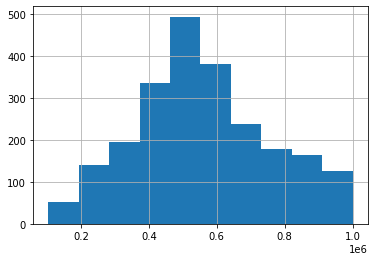

In [174]:
y_train.hist();

In [175]:
# Calculating baseline and showing
# Mean of y_train and MAE.
y_pred = [y_train.mean()]*len(X_train)
print('y training mean:', round(y_train.mean()))
print('Baseline MAE:', round(mean_absolute_error(y_train, y_pred)))

y training mean: 559718
Baseline MAE: 158708.0


# Build Model

## One-Hot Encoder

In [176]:
# Columns before transforming.
X_train.columns

Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [177]:
# Transforming the X_train data.

# Instantiate Transformer.
transf_1 = OneHotEncoder(use_cat_names=True, cols=['ZIP_CODE', 'BOROUGH'])

# Fit transformer to the data.
transf_1.fit(X_train)

# Transform our training data.
XT_train = transf_1.transform(X_train)

In [178]:
# Columns after transforming.
XT_train.columns

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'BLOCK', 'LOT', 'ZIP_CODE_11230.0', 'ZIP_CODE_11427.0',
       'ZIP_CODE_10461.0',
       ...
       'ZIP_CODE_10460.0', 'ZIP_CODE_11102.0', 'ZIP_CODE_11104.0',
       'ZIP_CODE_10459.0', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object', length=133)

In [179]:
# Before transformation.
X_train.head()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
SALE_DATE,,,,,,,,,,
2019-01-01,3,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
2019-01-01,4,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
2019-01-02,2,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
2019-01-02,3,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
2019-01-02,3,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1


In [180]:
# After transformation.
XT_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,BLOCK,LOT,ZIP_CODE_11230.0,ZIP_CODE_11427.0,ZIP_CODE_10461.0,ZIP_CODE_11226.0,ZIP_CODE_11203.0,ZIP_CODE_11364.0,ZIP_CODE_11373.0,ZIP_CODE_11365.0,ZIP_CODE_11429.0,ZIP_CODE_11414.0,ZIP_CODE_11369.0,ZIP_CODE_11413.0,ZIP_CODE_11434.0,ZIP_CODE_11435.0,ZIP_CODE_10312.0,ZIP_CODE_10308.0,ZIP_CODE_10314.0,ZIP_CODE_11236.0,ZIP_CODE_11228.0,ZIP_CODE_11207.0,ZIP_CODE_11218.0,ZIP_CODE_11210.0,ZIP_CODE_11229.0,ZIP_CODE_11234.0,ZIP_CODE_11411.0,ZIP_CODE_11362.0,ZIP_CODE_11691.0,ZIP_CODE_11354.0,ZIP_CODE_11367.0,ZIP_CODE_11366.0,ZIP_CODE_11423.0,ZIP_CODE_11432.0,ZIP_CODE_11385.0,...,ZIP_CODE_11219.0,ZIP_CODE_11375.0,ZIP_CODE_11436.0,ZIP_CODE_10470.0,ZIP_CODE_10475.0,ZIP_CODE_11220.0,ZIP_CODE_11214.0,ZIP_CODE_11004.0,ZIP_CODE_11224.0,ZIP_CODE_10453.0,ZIP_CODE_10462.0,ZIP_CODE_10464.0,ZIP_CODE_10458.0,ZIP_CODE_11368.0,ZIP_CODE_11209.0,ZIP_CODE_11416.0,ZIP_CODE_11235.0,ZIP_CODE_11692.0,ZIP_CODE_10468.0,ZIP_CODE_11232.0,ZIP_CODE_11105.0,ZIP_CODE_11233.0,ZIP_CODE_10456.0,ZIP_CODE_11238.0,ZIP_CODE_10455.0,ZIP_CODE_11372.0,ZIP_CODE_11221.0,ZIP_CODE_11225.0,ZIP_CODE_11213.0,ZIP_CODE_11415.0,ZIP_CODE_10460.0,ZIP_CODE_11102.0,ZIP_CODE_11104.0,ZIP_CODE_10459.0,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
SALE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,1325.0,1930.0,1
2019-01-01,0,1,0,0,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,2001.0,1940.0,1
2019-01-02,0,0,1,0,0,4210,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,2043.0,1925.0,1
2019-01-02,1,0,0,0,0,5212,69,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,2680.0,1899.0,1
2019-01-02,1,0,0,0,0,7930,121,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,1872.0,1940.0,1


## `SelectKBest`

In [181]:
# k is a HYPER-PARAMETER.
# To select k.

# Instantiate the Transformer.
transf_2 = SelectKBest(k=17)

# Fit transformer to the training data.
transf_2.fit(XT_train, y_train)

# Transform the training data.
XTT_train = transf_2.transform(XT_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4 115 120 132] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# Predictor

In [182]:
# Not usable.

# One-Hot Encoder

# Instantiate Model.
predictor_1 = LinearRegression()

# Fit model to training data.
predictor_1.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [183]:
# SelectKBest.

# Instantiate Model.
predictor_2 = LinearRegression()

# Fit model to training data.
predictor_2.fit(XTT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Check Metrics

Training Data Metric

In [184]:
# Not usable.

# One-Hot Encoder.

# Make predictions (TRANSFORMED training data).
y_pred = predictor_1.predict(XT_train)

# Calculate MAE
print('Training MAE:', mean_absolute_error(y_train, y_pred))

Training MAE: 107167.2400685117


In [185]:
# SelectKBest.

# Make predictions (TRANSFORMED training data).
y_pred = predictor_2.predict(XTT_train)

# Calculate MAE
print('Training MAE:', mean_absolute_error(y_train, y_pred))

Training MAE: 153328.2706358088


Validation Data Metric

In [186]:
# Not usable.

# One-Hot Encoder.

# Transform validation.
XT_val = transf_1.transform(X_val)

# Make predictions (TRANSFORMED validation data).
y_pred = predictor_1.predict(XT_val)

# Calculate MAE.
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 137720949923.2888


In [187]:
# SelectKBest.

# Transform validation
XTT_val = transf_2.transform(XT_val)

# Make predictions (TRANSFORMED validation data)
y_pred = predictor_2.predict(XTT_val)

# Calculate MAE
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 152007.7714405276


# Ridge Regression

In [188]:
# Alpha is a HYPER-PARAMETER.
# Instantiate.

predictor_2 = Ridge(alpha=0.7)

# Fit to training data.
predictor_2.fit(XTT_train, y_train)

Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [189]:
# Make predictions (TRANSFORMED training data).
y_pred = predictor_2.predict(XTT_train)

# Calculate MAE.
print('Training MAE:', mean_absolute_error(y_train, y_pred))

Training MAE: 153492.7142151265


In [190]:
# Transform validation.
XTT_val = transf_2.transform(XT_val)

# Make predictions (TRANSFORMED validation data).
y_pred = predictor_2.predict(XTT_val)

# Calculate MAE.
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 150856.00239650902


# Visualizing Coefficients

In [192]:
# Encoder
transf_1 = OneHotEncoder(use_cat_names=True)
XT_train = transf_1.fit_transform(X_train)

# Scaler
transf_2 = StandardScaler()
XTT_train = transf_2.fit_transform(XT_train)

# Predictor
predictor = Ridge(normalize=True)
predictor.fit(XTT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

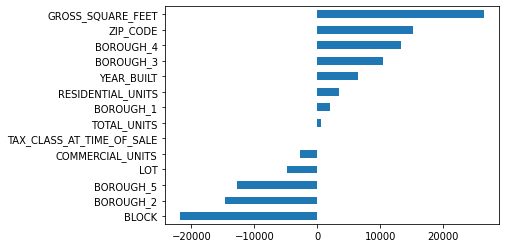

In [195]:
pd.Series(predictor.coef_, index=XT_train.columns).sort_values().plot(kind='barh');